In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
import re
import seaborn as sns 
import csv, sqlite3
import jieba  

matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
def re_encode(path):
    with open(path, 'r', encoding='GB2312', errors='ignore') as file:
        lines = file.readlines()
    with open(path, 'w', encoding='utf-8') as file:
        file.write(''.join(lines))
        
re_encode('nCoV_100k_train.labled.csv')

In [3]:

import pandas as pd
train_labled = pd.read_csv('nCoV_100k_train.labled.csv', engine ='python',encoding='utf-8')


train_labled.head(3)

,微博id,微博发布时间,发布人账号,微博中文内容,微博图片,微博视频,情感倾向
0,4.456070e+15,01月01日 23:50,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,['https://ww2.sinaimg.cn/orj360/005VnA1zly1gah...,[],0
1,4.456070e+15,01月01日 23:58,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,[],[],-1
2,4.456050e+15,01月01日 22:39,小王爷学辩论o_O,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新年...,['https://ww2.sinaimg.cn/thumb150/006ymYXKgy1g...,[],1


In [4]:
# 观察数据形状
print('数据形状：', train_labled.shape)
print('数据基本特征（不包含标签）:',train_labled.columns[:-2])
print('标签数据特征:',train_labled.columns[-1])
print('所有数据特征类型:\n',train_labled.dtypes)

数据形状： (100000, 7)
数据基本特征（不包含标签）: Index(['微博id', '微博发布时间', '发布人账号', '微博中文内容', '微博图片'], dtype='object')
标签数据特征: 情感倾向
所有数据特征类型:
 微博id      float64
微博发布时间     object
发布人账号      object
微博中文内容     object
微博图片       object
微博视频       object
情感倾向       object
dtype: object


In [5]:
train_labled['发布月份'] = ''
train_labled['发布日期'] = ''
train_labled['发布具体时间'] =''


months = []
dates = []
times = []

for i in train_labled['微博发布时间']:
    a = re.sub(r'月|日',' ',i).split()
    month = int(a[0])
    date = int(a[1])
    time = a[-1]
    months.append(month)
    dates.append(date)
    times.append(time)

train_labled['发布月份'] = months
train_labled['发布日期'] = dates
train_labled['发布具体时间'] = times

# 删除原来特征'微博发布时间'
train_labled = train_labled.drop(['微博发布时间'],axis=1)

# 观察处理之后的数据
train_labled.head(3)

,微博id,发布人账号,微博中文内容,微博图片,微博视频,情感倾向,发布月份,发布日期,发布具体时间
0,4.456070e+15,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,['https://ww2.sinaimg.cn/orj360/005VnA1zly1gah...,[],0,1,1,23:50
1,4.456070e+15,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,[],[],-1,1,1,23:58
2,4.456050e+15,小王爷学辩论o_O,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新年...,['https://ww2.sinaimg.cn/thumb150/006ymYXKgy1g...,[],1,1,1,22:39


In [6]:

target = train_labled['情感倾向'].unique()
untargets = []
for i in target:
    if i not in ['-1','0','1']:
        untargets.append(i)
print('异常标签数据类型有:',untargets)

train_labled = train_labled[train_labled['情感倾向'].isin(['-1','0','1'])]

print('数据标签:',train_labled['情感倾向'].unique())

print('删除异常标签数据之后的数据形状：',train_labled.shape)

异常标签数据类型有: ['-', '4', '-2', nan, '・', '10', '9']
数据标签: ['0' '-1' '1']
删除异常标签数据之后的数据形状： (99913, 9)


In [10]:
train_labled = train_labled.drop(['微博图片','微博视频'],axis=1)
train_labled.head(3)

,微博id,发布人账号,微博中文内容,情感倾向,发布月份,发布日期,发布具体时间
0,4.456070e+15,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,0,1,1,23:50
1,4.456070e+15,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,-1,1,1,23:58
2,4.456050e+15,小王爷学辩论o_O,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新年...,1,1,1,22:39


In [11]:
# 预处理之后数据预览

print('数据形状：',train_labled.shape)
print('数据特征：\n',train_labled.columns)
print('数据预览')
train_labled.head(5)

数据形状： (99560, 7)
数据特征：
 Index(['微博id', '发布人账号', '微博中文内容', '情感倾向', '发布月份', '发布日期', '发布具体时间'], dtype='object')
数据预览


,微博id,发布人账号,微博中文内容,情感倾向,发布月份,发布日期,发布具体时间
0,4.456070e+15,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,0,1,1,23:50
1,4.456070e+15,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,-1,1,1,23:58
2,4.456050e+15,小王爷学辩论o_O,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新年...,1,1,1,22:39
3,4.456060e+15,芩r,新年的第一天感冒又发烧的也太衰了但是我要想着明天一定会好的?,1,1,1,23:08
4,4.455980e+15,changlwj,问：我们意念里有坏的想法了，天神就会给记下来，那如果有好的想法也会被记下来吗？答：那当然了。...,1,1,1,17:42


In [12]:
train_labled['情感倾向'].describe()

count     99560
unique        3
top           0
freq      57287
Name: 情感倾向, dtype: object

In [13]:
month = train_labled['发布月份'].unique()
nums = []
for i in month:
    test = train_labled
    
    num = train_labled[train_labled['发布月份']==i]['微博id'].count()
    nums.append(num)
    
for i in range(month.shape[0]):
    print('{}月份，有关新冠疫情的微博留言数量:{}'.format(month[i], nums[i]))

1月份，有关新冠疫情的微博留言数量:47981
2月份，有关新冠疫情的微博留言数量:51579


In [14]:
train_labled['发布月份'] = train_labled['发布月份'].astype(int)
train_labled['发布日期'] = train_labled['发布日期'].astype(int)

test1 = train_labled[train_labled['发布月份']==1]
test2 = train_labled[train_labled['发布月份']==2]
nms1 = test1[test1['发布日期']>=25]['微博id'].count()
nms2 = test2[test2['发布日期']<=3]['微博id'].count()
nums = nms1+nms2
print('1月25-2月3期间，相关微博留言数量共计:',nums)

1月25-2月3期间，相关微博留言数量共计: 26277


## 数据可视化分析

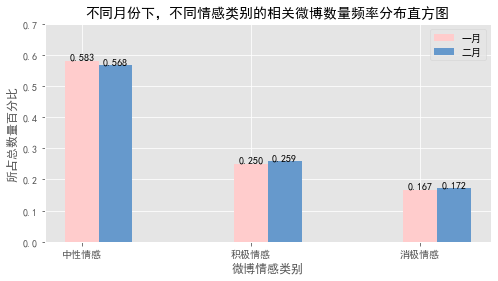

In [16]:

train_labled['情感倾向'] = train_labled['情感倾向'].astype(int)

# 绘制条形图
# 绘图尺寸
fig = plt.figure()
fig.set_size_inches(8, 4)

# 设置x轴、y轴
y1 = train_labled[train_labled['发布月份']==1]['情感倾向'].value_counts(normalize=True)
y2 = train_labled[train_labled['发布月份']==2]['情感倾向'].value_counts(normalize=True)
label = ['中性情感','积极情感','消极情感']
x=np.arange(3)+0.2 # 实现并列柱状图

rects1 = plt.bar(label,y1,color='#FFCCCC',width=0.2,label ='一月' )  
rects2 = plt.bar(x,y2,color='#6699CC',width=0.2,label ='二月') 

# 为每个条形柱标上数值
for rect in rects1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, format(height,'.3f'), ha="center", va="bottom",fontsize=10)
        
# 为每个条形柱标上数值
for rect in rects2:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, format(height,'.3f'), ha="center", va="bottom",fontsize=10)
        
plt.ylim(0,0.7)
plt.xlabel('微博情感类别',fontsize=12)  # x轴标签 
plt.ylabel('所占总数量百分比',fontsize=12)  # y轴标签 
plt.title('不同月份下，不同情感类别的相关微博数量频率分布直方图',fontsize=14)  # 标题
plt.style.use('ggplot')  # 绘图风格
plt.xticks(size = 10)  # 设置x轴坐标刻度字体大小
plt.yticks(size = 10)  # 设置y轴坐标刻度字体大小
plt.legend()
plt.show()

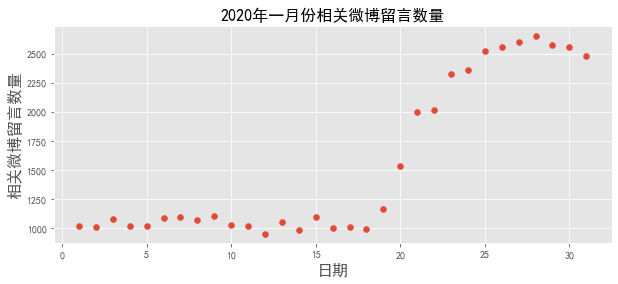

In [17]:
# 3.2020年一月份相关微博留言数量
date = train_labled['发布日期'].unique()

nums1 = []  # 创建空列表用于存储一月份微博数量
for i in date:
    test = train_labled[train_labled['发布月份']==1]
    num = test[test['发布日期']==i]['微博id'].count()
    nums1.append(num)


x = date 
y1 = nums1


# 绘图尺寸
fig = plt.figure()
fig.set_size_inches(10, 4)

plt.scatter(x,y1)

plt.style.use('ggplot') # 绘图风格
plt.title('2020年一月份相关微博留言数量',fontsize=16)  # 标题
plt.xlabel('日期', fontsize=16)
plt.ylabel('相关微博留言数量', fontsize=16)

# plt.legend()  # 设置样例以区分
plt.show()  

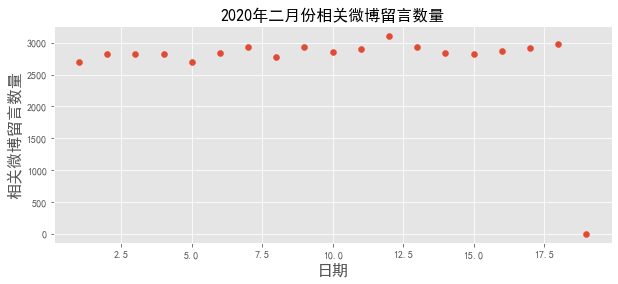

In [18]:
# 4.2020年二月份相关微博留言数量
date = train_labled[train_labled['发布月份']==2]['发布日期'].unique()

nums1 = []  # 创建空列表用于存储二月份微博数量
for i in date:
    test = train_labled[train_labled['发布月份']==2]
    num = test[test['发布日期']==i]['微博id'].count()
    nums1.append(num)


x = date 
y1 = nums1


# 绘图尺寸
fig = plt.figure()
fig.set_size_inches(10, 4)

plt.scatter(x,y1)

plt.style.use('ggplot') # 绘图风格
plt.title('2020年二月份相关微博留言数量',fontsize=16)  # 标题
plt.xlabel('日期', fontsize=16)
plt.ylabel('相关微博留言数量', fontsize=16)

# plt.legend()  # 设置样例以区分
plt.show()  

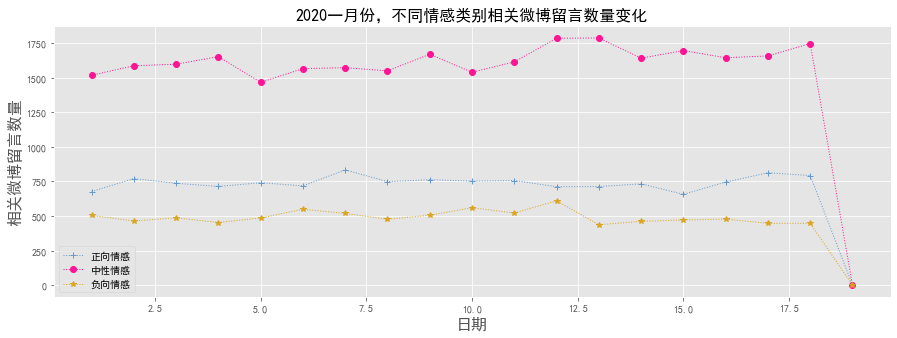

In [20]:
# 6. 2020二月份，不同情感类别相关微博留言数量变化

date = train_labled[train_labled['发布月份']==2]['发布日期'].unique()

nums1 = []  # 创建空列表用于存储二月份正向情感微博数量
for i in date:
    test = train_labled[train_labled['发布月份']==2]
    test = test[test['情感倾向']==1]
    num = test[test['发布日期']==i]['微博id'].count()
    nums1.append(num)
    
nums2 = []  # 创建空列表用于存储二月份中性情感微博数量
for i in date:
    test = train_labled[train_labled['发布月份']==2]
    test = test[test['情感倾向']==0]
    num = test[test['发布日期']==i]['微博id'].count()
    nums2.append(num)
    
nums3 = []  # 创建空列表用于存储二月份负向情感微博数量
for i in date:
    test = train_labled[train_labled['发布月份']==2]
    test = test[test['情感倾向']==-1]
    num = test[test['发布日期']==i]['微博id'].count()
    nums3.append(num)
    
x_index = date.argsort()  # 将日期从小到达排列，并返回对应索引

# 设置x、y轴
x = date[x_index]
y1 = np.array(nums1)[x_index]
y2 = np.array(nums2)[x_index]
y3 = np.array(nums3)[x_index]


# 绘图尺寸
fig = plt.figure()
fig.set_size_inches(15, 5)

plt.plot(x,y1,label='正向情感',color="#6699CC",linestyle=':',linewidth=1, marker='+')
plt.plot(x,y2,label='中性情感',color="deeppink",linestyle=':',linewidth=1, marker='o')
plt.plot(x,y3,label='负向情感',color="goldenrod",linestyle=':',linewidth=1, marker='*')

plt.style.use('ggplot') # 绘图风格
plt.title('2020一月份，不同情感类别相关微博留言数量变化',fontsize=16)  # 标题
plt.xlabel('日期', fontsize=16)
plt.ylabel('相关微博留言数量', fontsize=16)

plt.legend()  # 设置样例以区分
plt.show()  

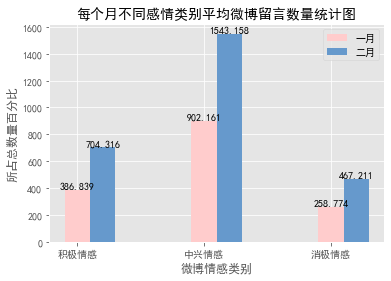

In [21]:
# 7 每个月不同感情类别平均微博留言数量统计图

# 创建不同月份的微博数据，用于后续处理
test1 = train_labled[train_labled['发布月份']==1]
test2 = train_labled[train_labled['发布月份']==2]

# 创建空列表用于存储数据
num1_mean = []
num2_mean = []

date1 = test1['发布日期'].unique()
date2 = test2['发布日期'].unique()


# 直接计算，循环可以选择是否使用，这里不适用
num1_mean.append(test1[test1['情感倾向']==1]['微博id'].count()/len(date1))
num1_mean.append(test1[test1['情感倾向']==0]['微博id'].count()/len(date1))
num1_mean.append(test1[test1['情感倾向']==-1]['微博id'].count()/len(date1))

num2_mean.append(test2[test2['情感倾向']==1]['微博id'].count()/len(date2))
num2_mean.append(test2[test2['情感倾向']==0]['微博id'].count()/len(date2))
num2_mean.append(test2[test2['情感倾向']==-1]['微博id'].count()/len(date2))

# 设置x轴、y轴
y1 = num1_mean
y2 = num2_mean
label = ['积极情感','中兴情感','消极情感']
x=np.arange(3)+0.2 # 实现并列柱状图

rects1 = plt.bar(label,y1,color='#FFCCCC',width=0.2,label ='一月' )  
rects2 = plt.bar(x,y2,color='#6699CC',width=0.2,label ='二月') 

# 为每个条形柱标上数值
for rect in rects1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, format(height,'.3f'), ha="center", va="bottom",fontsize=10)
        
# 为每个条形柱标上数值
for rect in rects2:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, format(height,'.3f'), ha="center", va="bottom",fontsize=10)
        

plt.xlabel('微博情感类别',fontsize=12)  # x轴标签 
plt.ylabel('所占总数量百分比',fontsize=12)  # y轴标签 
plt.title('每个月不同感情类别平均微博留言数量统计图',fontsize=14)  # 标题
plt.style.use('ggplot')  # 绘图风格
plt.xticks(size = 10)  # 设置x轴坐标刻度字体大小
plt.yticks(size = 10)  # 设置y轴坐标刻度字体大小
plt.legend()
plt.show()


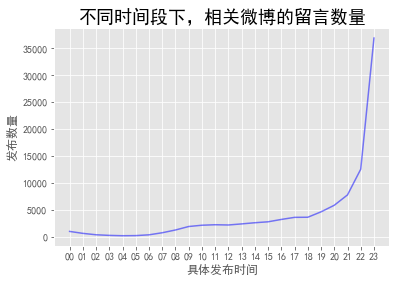

In [22]:
test1 = train_labled['发布具体时间'].values.tolist()

times= []
for i in range(len(test1)):
    time = test1[i].split(':')[0]
    times.append(time)

test2 = train_labled['情感倾向'].values.tolist()

test3 = pd.DataFrame({'发布具体时间':times})

x_index = test3['发布具体时间'].unique().argsort()
x = test3['发布具体时间'].unique()[test3['发布具体时间'].unique().argsort()]

nums = []
for i in x:
    num = test3[test3['发布具体时间']==i]['发布具体时间'].count()
    nums.append(num)
y = nums

# 绘制条形图
# 绘图尺寸
fig = plt.figure()
fig.set_size_inches(6, 4)


plt.plot(x,y,color='blue',alpha=0.5)
        
plt.xlabel('具体发布时间',fontsize=12)  # x轴标签 
plt.ylabel('发布数量',fontsize=12)  # y轴标签 
plt.title('不同时间段下，相关微博的留言数量',fontsize=18)  # 标题
plt.style.use('ggplot')  # 绘图风格
plt.xticks(size = 10)  # 设置x轴坐标刻度字体大小
plt.yticks(size = 10)  # 设置y轴坐标刻度字体大小
plt.show()

In [23]:
print(train_labled.dtypes)
train_labled["情感倾向"] = pd.to_numeric(train_labled["情感倾向"],errors='coerce')

微博id       int64
发布人账号     object
微博中文内容    object
情感倾向       int32
发布月份       int32
发布日期       int32
发布具体时间    object
dtype: object


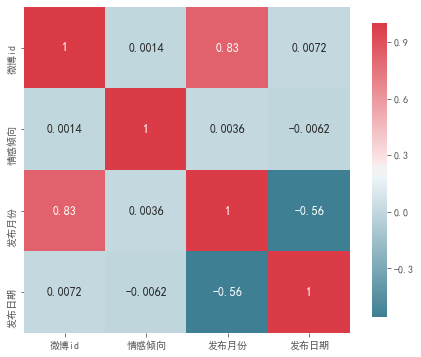

In [24]:
_, ax = plt.subplots(figsize=(8, 6))  
corr = train_labled.corr(method='pearson')  
cmap = sns.diverging_palette(220, 10, as_cmap=True)  
_ = sns.heatmap(
    corr,  
    cmap=cmap,  
    square=True,  
    cbar_kws={'shrink': .9}, 
    ax=ax,  
    annot=True,  
    annot_kws={'fontsize': 12}) 

plt.show()